# Wine grape detection

Simple model for object detection.

Ideas taken from CenterNet, [arXiv:1904.07850 [cs.CV]](https://arxiv.org/abs/1904.07850)

For each cell in the output model proposes a bounding box with the center in that cell
and a prediction of IoU between proposed box and ground truth.

Model can have architecture similar to segmentation models.

Loss
$$
\mathcal{L} = \mathcal{L}_{\mathrm{conf}} + \mathcal{L}_{\mathrm{geom}}
$$
consists of two parts: IoU prediction loss $\mathcal{L}_{\mathrm{conf}}$ and loss for bounding box geometry $\mathcal{L}_{\mathrm{geom}}$.
Loss $\mathcal{L}_{\mathrm{conf}}$ is binary cross entropy loss between predicted and actual IoUs,
$$
\mathcal{L}_{\mathrm{conf}} = \mathrm{CE}(\mathrm{IoU}_{\mathrm{predicted}}, \mathrm{IoU}_{\mathrm{calculated}})\,,
$$
whereas $\mathcal{L}_{\mathrm{iou}}$ maximizes IoUs of proposed bounding boxes
$$
\mathcal{L}_{\mathrm{geom}} = 1-\sum_{b\in\mathrm{boxes}}\mathrm{IoU}_b
$$

Maximum of IoU can be only for a bounding box having the center coinciding with the center of the ground truth box. Thus locations of ground truth can be found by searching for peaks in the predicted IoUs.

Such a method can potentially avoid employing non-maximum supression.

Dataset: [Embrapa Wine Grape Instance Segmentation Dataset](https://github.com/thsant/wgisd)

Download:
```
git clone https://github.com/thsant/wgisd.git
```

## Configuration

Imports

In [1]:
import warnings

In [2]:
warnings.simplefilter('ignore')

In [3]:
from pathlib import Path
from functools import partial
from collections import defaultdict
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import tqdm
import tqdm.autonotebook
tqdm.autonotebook.tqdm = tqdm.tqdm # hack to force ASCII output everywhere
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import ops
import torchvision.transforms.functional as TF

import albumentations as A

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [4]:
WGISD_ROOT = Path('./wgisd/')
DATA_DIR = WGISD_ROOT / 'data'
TRAIN_LIST = WGISD_ROOT / 'train.txt'
TEST_LIST = WGISD_ROOT / 'test.txt'

MODELS_DIR = Path('./models')

VAL_RATIO = 0.1

IMAGE_SIZE = 512

NUM_WORKERS = 8
BATCH_SIZE = 16
EPOCHS = 1000

LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [5]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Loss

Loss
$$
\mathcal{L} = \mathcal{L}_{\mathrm{conf}} + \mathcal{L}_{\mathrm{geom}}\,,
$$
where $\mathcal{L}_{\mathrm{conf}}$ is binary cross entropy loss between predicted and actual IoUs,
$$
\mathcal{L}_{\mathrm{conf}} = \mathrm{CE}(\mathrm{IoU}_{\mathrm{predicted}}, \mathrm{IoU}_{\mathrm{calculated}})\,,
$$
and
$$
\mathcal{L}_{\mathrm{geom}} = 1-\sum_{b\in\mathrm{boxes}}\mathrm{IoU}_b
$$

In [6]:
def batch_box_area(boxes):
    return (boxes[..., 2] - boxes[..., 0]) * (boxes[..., 3] - boxes[..., 1])

In [7]:
def batch_box_iou(boxes_gt,   # shape: (b, n_gt, 4)
                  boxes_pred, # shape: (b, n_pred, 4)
                  eps=1e-7):
    
    lt = torch.max(boxes_gt[..., None, :2], boxes_pred[..., None, :, :2])
    rb = torch.min(boxes_gt[..., None, 2:], boxes_pred[..., None, :, 2:])

    wh = (rb - lt).clamp(min=0) 
    inter = wh[..., 0] * wh[..., 1] # shape: (b, n_gt, n_pred)
    
    area_gt = batch_box_area(boxes_gt)[..., None]
    area_pred = batch_box_area(boxes_pred)[..., None, :]
    
    iou = inter / (area_gt + area_pred - inter + eps)
    return iou

In [8]:
class DetectionLoss(nn.Module):
    def __init__(self, λ_conf=1.0, λ_geom=1.0):
        super().__init__()
        self.λ_conf = λ_conf
        self.λ_geom = λ_geom
        self.conf_loss = nn.BCELoss()
    
    def forward(self, output, target):
        if target.size(1) == 0:
            target = torch.zeros((target.size(0), 1, 4), device=target.device)
        
        output = output.flatten(1, 2)
        pred_bboxes = output[..., :4]
        pred_ious = output[..., 4]
        
        true_ious = batch_box_iou(target, pred_bboxes)
        true_ious, _ = torch.max(true_ious, dim=1)
        
        conf_loss = self.conf_loss(pred_ious, true_ious.detach())
        geom_loss = 1. - torch.mean(true_ious)
        loss = self.λ_conf * conf_loss + self.λ_geom * geom_loss
        return loss

## Model

Model can have architecture similar to segmentation models.

For each cell in the output model proposes a bounding box with the center in that cell
and a prediction of IoU between proposed box and ground truth.

### Encoder

In [9]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
          nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
          nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [10]:
class DownBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, 3)
        )

In [11]:
class Encoder(nn.Module):
    def __init__(self, in_channels, channels, num_downsamplings):
        super().__init__()
        self.stem = ConvBlock(in_channels, channels, 3)
        
        self.blocks = nn.ModuleList()
        in_channels = channels
        for _ in range(num_downsamplings):
            out_channels = in_channels * 2
            self.blocks.append(DownBlock(in_channels, out_channels))
            in_channels = out_channels
    
    def forward(self, x):
        x = self.stem(x)
        
        xs = []
        for block in self.blocks:
            xs.append(x)
            x = block(x)
        return x, xs

### Decoder

In [12]:
class UpBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, out_channels, 3, act=False),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

In [13]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = UpBlock(in_channels, out_channels)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.act = nn.ReLU(inplace=True)
    
    def forward(self, x, skip):
        x = self.up(x)
        out = skip + self.gamma * x
        return self.act(out)    

In [14]:
class Head(nn.Sequential):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, hidden_channels, 3),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        )

In [15]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_upsamplings):
        super().__init__()
        self.up = nn.ModuleList()
        for _ in range(num_upsamplings):
            channels = in_channels // 2
            self.up.append(Up(in_channels, channels))
            in_channels = channels
        
        self.head = Head(channels, channels, out_channels)
    
    def forward(self, x, xs):
        for up_layer, skip in zip(self.up, reversed(xs)):
            x = up_layer(x, skip)
        x = self.head(x)
        return x

### Full model

In [16]:
class Net(nn.Module):
    def __init__(self, num_downsamplings, num_upsamplings, channels=32, in_channels=3):
        super().__init__()
        self.encoder = Encoder(in_channels, channels, num_downsamplings)
        self.decoder = Decoder(channels * 2**num_downsamplings, 5, num_upsamplings)

    def forward(self, x):
        x, xs = self.encoder(x)
        out = self.decoder(x, xs)
        out = torch.sigmoid(out)
        boxes = self.to_boxes(out)
        return boxes
        
    def to_boxes(self, out):
        h, w = out.shape[2:]

        grid_x = torch.arange(w, device=out.device).unsqueeze(0)
        grid_y = torch.arange(h, device=out.device).unsqueeze(1)
        cx = (out[:, 0] + grid_x) / w
        cy = (out[:, 1] + grid_y) / h
        pred_w = out[:, 2]
        pred_h = out[:, 3]
        
        x1 = cx - 0.5 * pred_w
        y1 = cy - 0.5 * pred_h
        x2 = cx + 0.5 * pred_w
        y2 = cy + 0.5 * pred_h
        
        scores = out[:, 4]
        boxes = torch.stack((x1, y1, x2, y2, scores), dim=3)
        return boxes

Training is more stable when initially model proposes small bounding boxes having the size of the output cell

In [17]:
def init_model(model, image_size, num_downsamplings, num_upsamplings):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)

    m = model.decoder.head[-1]
    nn.init.zeros_(m.weight)
    output_size = image_size // 2**(num_downsamplings - num_upsamplings)
    nn.init.constant_(m.bias, -np.log(output_size - 1))

In [18]:
model = Net(num_downsamplings=5, num_upsamplings=3, channels=32).to(DEVICE)

In [19]:
init_model(model, IMAGE_SIZE, num_downsamplings=5, num_upsamplings=3)

In [20]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 12,633,512


## Data

### Reading of bounding box information

In [21]:
def get_file_list(list_name):
    with open(list_name) as f:
        file_list = f.readlines()
    file_list = [file_name.strip() for file_name in file_list]
    return file_list

In [22]:
def read_annotation(annotation_path):
    bboxes = []
    try:
        with open(annotation_path) as f:
            for line in f:
                label, x_center, y_center, width, height = [float(s) for s in line.split()]
                x1 = max(x_center - 0.5 * width, 0.)
                y1 = max(y_center - 0.5 * height, 0.)
                x2 = min(x_center + 0.5 * width, 1.)
                y2 = min(y_center + 0.5 * height, 1.)
                if x1 < x2 and y1 < y2:
                    bbox = [x1, y1, x2, y2]
                    bboxes.append(bbox)
                else:
                    print("Invalid bounding box", annotation_path)
    
    except FileNotFoundError:
        print("Annotation missing:", annotation_path)

    return bboxes

In [23]:
def read_bounding_boxes(file_list):
    images_data = []
    for name in file_list:
        image_name = name + '.jpg'
        annotation_name = name + '.txt'
        image_path = DATA_DIR / image_name
        annotation_path = DATA_DIR / annotation_name
        bboxes = read_annotation(annotation_path)
        data = {'file_name': image_path, 'bboxes': bboxes}
        images_data.append(data)
            
    return images_data

In [24]:
train_val_list = get_file_list(TRAIN_LIST)

In [25]:
test_list = get_file_list(TEST_LIST)

In [26]:
train_list, val_list = train_test_split(train_val_list, test_size=VAL_RATIO, random_state=0,
                                        shuffle=True)

In [27]:
print("Number of train images:", len(train_list))
print("Number of validation images:", len(val_list))
print("Number of train+validation images:", len(train_list) + len(val_list))
print("Number of test images:", len(test_list))
print("Total number of images:", len(train_list) + len(val_list) + len(test_list))

Number of train images: 217
Number of validation images: 25
Number of train+validation images: 242
Number of test images: 58
Total number of images: 300


In [28]:
train_data = read_bounding_boxes(train_list)
val_data = read_bounding_boxes(val_list)
test_data = read_bounding_boxes(test_list)

### Utilities

Convert from scaled tensors to unscaled bounding boxes

In [29]:
def denormalize_bboxes(bboxes, shape):
    wh = torch.tensor([shape[1], shape[0]])
    bboxes = torch.cat((bboxes[:, :2] * wh, bboxes[:, 2:] * wh), axis=1)
    return bboxes

Plotting

In [30]:
def plot_image(image):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(image)
    plt.show()

In [31]:
def plot_image_bounding_boxes(image, bboxes, bboxes_gt=None):
    image = TF.convert_image_dtype(image, dtype=torch.uint8)
    image_bboxes = torchvision.utils.draw_bounding_boxes(image=image, boxes=bboxes, colors='red', width=2)
    if bboxes_gt is not None:
        image_bboxes = torchvision.utils.draw_bounding_boxes(image=image_bboxes, boxes=bboxes_gt, colors='blue', width=2)
    image_bboxes = TF.to_pil_image(image_bboxes)
    plot_image(image_bboxes)

### Dataset

In [32]:
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images_data, transform=None):
        self.images_data = images_data
        self.transform = transform
    
    def __len__(self):
        return len(self.images_data)
    
    def __getitem__(self, idx):
        img_data = self.images_data[idx]
        file_path = img_data['file_name']
        image = Image.open(file_path)
        image = image.convert('RGB')
        image = np.array(image)
        
        bboxes = img_data['bboxes']
        labels = [0] * len(bboxes)
        
        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=bboxes, labels=labels)
            image, bboxes = transformed['image'], transformed['bboxes']
        
        if len(bboxes) > 0:
            bboxes = torch.tensor(bboxes, dtype=torch.float32)
        else:
            bboxes = torch.zeros((0, 4), dtype=torch.float32)
        
        image = TF.to_tensor(image)
        
        return image, bboxes
    
    def show_image(self, idx):
        image, bboxes = self[idx]
        bboxes = denormalize_bboxes(bboxes, image.shape[1:])
        plot_image_bounding_boxes(image, bboxes)

In [33]:
train_transform = A.Compose([
    A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-10, 10),
        shear=(-8, 8),
        mode=cv2.BORDER_REFLECT,
        p=1
    ),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)
], bbox_params=A.BboxParams(format='albumentations', min_visibility=0.1, label_fields=['labels']))

In [34]:
val_transform = A.Compose([
    A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE)
], bbox_params=A.BboxParams(format='albumentations', label_fields=['labels']))

In [35]:
train_dset = ImagesDataset(train_data, train_transform)

In [36]:
val_dset = ImagesDataset(val_data, val_transform)

In [37]:
test_dset = ImagesDataset(test_data, val_transform)

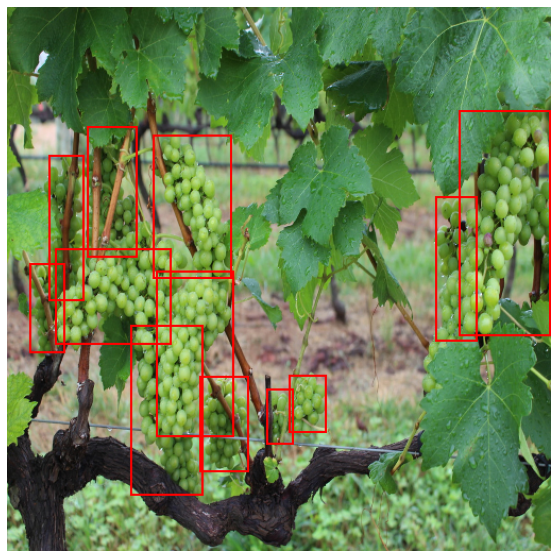

In [38]:
val_dset.show_image(0)

### DataLoader

Pad ground truth bounding boxes to allow a formation of batch tensor.

In [39]:
def extend_tensor(t, max_len):
    l = len(t)
    if l < max_len:
        z = torch.zeros((max_len - l,) + t.shape[1:])
        return torch.cat((t, z), dim=0)
    else:
        return t

In [40]:
def collate_fn(batch):
    images, bboxes = zip(*batch)
    
    images_tens = torch.stack(images, dim=0)

    max_bboxes = max(len(bbs) for bbs in bboxes)
    bboxes_tens = [extend_tensor(bbs, max_bboxes) for bbs in bboxes]
    bboxes_tens = torch.stack(bboxes_tens, dim=0)

    return images_tens, bboxes_tens

In [41]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn,
                                           num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         collate_fn=collate_fn,
                                         num_workers=NUM_WORKERS, pin_memory=True)

In [42]:
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn,
                                          num_workers=NUM_WORKERS, pin_memory=True)

## Metrics

Output preprocessing

from https://github.com/xingyizhou/CenterNet

In [43]:
def heatmap_peaks(heat, kernel=3):
    pad = (kernel - 1) // 2
    hmax = nn.functional.max_pool2d(heat.unsqueeze(1), (kernel, kernel), stride=1, padding=pad).squeeze(1)
    peaks = (hmax == heat)
    return peaks

In [44]:
def remove_zero_boxes(boxes):
    mask = ~ (boxes == 0.).all(dim=-1)
    return boxes[mask]

In [45]:
class DetectionMetrics(ignite.metrics.Metric):
    def __init__(self, threshold=0.5, iou_threshold=0.5, nms_threshold=0.5, heatmap_kernel=3,
                 output_transform=lambda x: x, device="cpu"):
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.nms_threshold = nms_threshold
        self.heatmap_kernel = heatmap_kernel
        super().__init__(output_transform=output_transform, device=device)
    
    def reset(self):
        self._num_true = 0
        super().reset()
    
    def update(self, data):
        outputs, true_bboxes = data[0].detach(), data[1].detach()
        
        pred_ious = outputs[..., 4]
        pred_bboxes = outputs[..., :4]
        
        peaks = heatmap_peaks(pred_ious, kernel=self.heatmap_kernel)
        masks = peaks & (pred_ious > self.threshold)
        
        for true_boxes, pred_boxes, conf, mask in zip(true_bboxes, pred_bboxes, pred_ious, masks):
            true_boxes = remove_zero_boxes(true_boxes)
            
            pred_boxes = pred_boxes[mask]
            conf = conf[mask]
            
            keep_idx = ops.nms(pred_boxes, conf, self.nms_threshold)
            pred_boxes = pred_boxes[keep_idx]
            conf = conf[keep_idx]
            
            if len(pred_boxes) > 0 and len(true_boxes) > 0:
                ious = ops.box_iou(pred_boxes, true_boxes)
                
                # zero all non_maximum values for a given ground truth box
                idx = ious.argmax(dim=0, keepdims=True)
                ious = torch.zeros_like(ious).scatter_(0, idx, ious.gather(0, idx))
                
                is_true_positive = ious > self.iou_threshold
                is_true_positive = is_true_positive.any(dim=1)
            else:
                is_true_positive = torch.zeros_like(conf, dtype=torch.bool)
            
            self._num_true += len(true_boxes)
            self.process_batch(is_true_positive, conf)

Simple F1 score for evaluation during training

In [46]:
class F1(DetectionMetrics):
    def reset(self):
        self._num_pred = 0
        self._num_tp = 0
        super().reset()
    
    def process_batch(self, is_true_positive, conf):
        self._num_pred += len(conf)
        self._num_tp += is_true_positive.sum().item()
    
    def compute(self):
        prec = self._num_tp / (self._num_pred + 1e-7)
        rec = self._num_tp / (self._num_true + 1e-7)
        f1 = 2 * prec * rec / (prec + rec + 1e-7)
        return f1

Average precsion AP using all-point interpolation

In [47]:
class AveragePrecision(DetectionMetrics):
    def __init__(self, iou_threshold=0.5, nms_threshold=0.5, heatmap_kernel=3,
                 output_transform=lambda x: x, device="cpu"):
        super().__init__(threshold=0., iou_threshold=iou_threshold,
                         nms_threshold=nms_threshold, heatmap_kernel=heatmap_kernel,
                         output_transform=output_transform, device=device)
    
    def reset(self):
        self._tp_list = []
        self._confidence_list = []
        super().reset()
    
    def process_batch(self, is_true_positive, conf):
        self._confidence_list.append(conf)
        tp = torch.zeros_like(conf)
        tp[is_true_positive] = 1.
        self._tp_list.append(tp)
    
    def compute(self):
        conf = torch.cat(self._confidence_list)
        tp = torch.cat(self._tp_list)
        
        # sort true positives according to confidence
        idx = conf.argsort(descending=True)
        tp = tp[idx]
        
        # cumulative sum of true positives and false positives
        tpc = tp.cumsum(0)
        fpc = (1. - tp).cumsum(0)
        
        # precision and recall curves
        recall = tpc / (self._num_true + 1e-7)
        precision =  tpc / (tpc + fpc)
        
        # append sentinel values to beginning and end
        z = torch.zeros(1, device=self._device)
        o = torch.ones(1, device=self._device)
        recall = torch.cat([z, recall, o])
        precision = torch.cat([o, precision, z])
        
        # compute precision envelope
        precision = precision.flip(0)
        precision, _ = precision.cummax(0)
        precision = precision.flip(0)
        
        # integrate area under curve
        idx = (recall[1:] != recall[:-1]).nonzero(as_tuple=True)[0] # indexes where recall changes
        ap = ((recall[idx + 1] - recall[idx]) * precision[idx + 1]).sum().item() # area under curve
        
        return ap

## Training

### Setup Trainer

In [48]:
params = [p for p in model.parameters() if p.requires_grad]

In [49]:
optimizer = optim.AdamW(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [50]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [51]:
loss = DetectionLoss()

Trainer

In [52]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [53]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [54]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [55]:
pbar = ignite.contrib.handlers.ProgressBar(persist=True, ncols=100)

In [56]:
pbar.attach(trainer, event_name=Events.EPOCH_COMPLETED, closing_event_name=Events.COMPLETED)

Evaluator

In [57]:
evaluator = create_supervised_evaluator(model,
                metrics={"F1": F1(device=DEVICE), "loss": ignite.metrics.Loss(loss)},
                device=DEVICE)

In [58]:
best_handler = ignite.handlers.Checkpoint({'model': model},
    ignite.handlers.DiskSaver(MODELS_DIR, create_dir=False, require_empty=False),
    n_saved=1, filename_prefix='best',
    score_function=ignite.handlers.Checkpoint.get_default_score_fn("F1"),
    score_name="val_F1",
    global_step_transform=ignite.handlers.global_step_from_engine(trainer)
)

In [59]:
evaluator.add_event_handler(Events.COMPLETED, best_handler);

In [60]:
history = defaultdict(list)

In [61]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_f1 = val_metrics["F1"]
    history['val loss'].append(val_loss)
    history['val F1'].append(val_f1)
    
    pbar.pbar.set_postfix({"train loss": f"{train_loss:.3f}",
                           "val loss": f"{val_loss:.3f}", "val F1": f"{val_f1:.3f}"})

### Start training

In [62]:
trainer.run(train_loader, max_epochs=EPOCHS);

Epoch: [1000/1000] 100%|████████████, train loss=1.224, val loss=1.239, val F1=0.777 [1:27:28<00:00]


In [63]:
torch.save(model.state_dict(), str(MODELS_DIR / 'final_model.pt'))

### Plotting

In [64]:
def show_or_save(fig, filename=None):
    if filename:
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

In [65]:
def history_plot_train_val(history, key, filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    show_or_save(fig, filename)

In [66]:
def history_plot(history, key, filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '.-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    show_or_save(fig, filename)

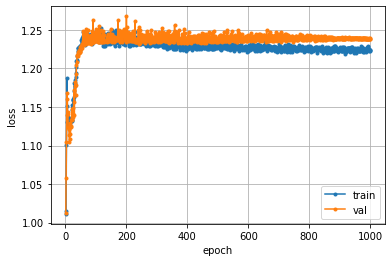

In [67]:
history_plot_train_val(history, 'loss')

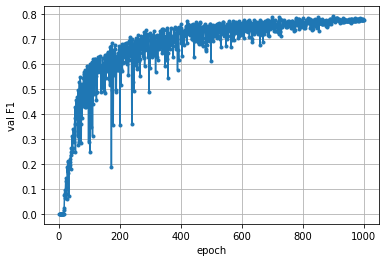

In [68]:
history_plot(history, 'val F1')

## Testing

In [48]:
def evaluate_metric(model, metric, loader, device, **kwargs):
    name = metric.__name__
    evaluator = create_supervised_evaluator(model,
                metrics={name: metric(device=device, **kwargs)},
                device=device)
    evaluator.run(loader)
    val_metric = evaluator.state.metrics[name]
    return val_metric

In [49]:
#model.load_state_dict(torch.load(str(MODELS_DIR / best_handler.last_checkpoint)))
model.load_state_dict(torch.load(str(MODELS_DIR / 'final_model.pt')))

<All keys matched successfully>

In [50]:
model.eval();

In [51]:
thresholds = np.linspace(0., 1.0, num=50)
f1_vs_thr = [evaluate_metric(model, F1, val_loader, DEVICE, threshold=thr) for thr in tqdm(thresholds)]

100%|███████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


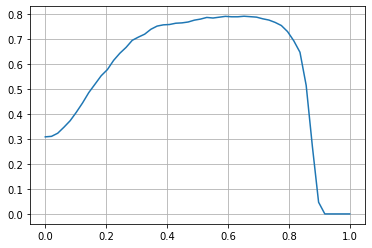

In [52]:
plt.plot(thresholds, f1_vs_thr);
plt.grid();

In [53]:
num = np.argmax(f1_vs_thr)
best_thr = thresholds[num]
best_f1 = f1_vs_thr[num]
print(f"Best F1 {best_f1:.3f} for threshold {best_thr:.3f}")

Best F1 0.790 for threshold 0.653


In [54]:
test_f1 = evaluate_metric(model, F1, test_loader, DEVICE, threshold=best_thr)
print(f"Test F1: {test_f1:.3f}")

Test F1: 0.785


In [55]:
test_ap = evaluate_metric(model, AveragePrecision, test_loader, DEVICE)
print(f"Test AP: {test_ap:.3f}")

Test AP: 0.710


### Example

In [56]:
def output_to_bboxes(output, shape, threshold=0.5, nms_threshold=0.5, heatmap_kernel=3):
    pred_ious = output[..., 4]
    pred_boxes = output[..., :4]
    
    peaks = heatmap_peaks(pred_ious.unsqueeze(0), kernel=heatmap_kernel).squeeze(0)
    mask = peaks & (pred_ious > threshold)
    
    pred_boxes = pred_boxes[mask]
    pred_ious = pred_ious[mask]
    
    keep_idx = ops.nms(pred_boxes, pred_ious, nms_threshold)
    pred_boxes = pred_boxes[keep_idx]
    pred_ious = pred_ious[keep_idx]
    
    bboxes = denormalize_bboxes(pred_boxes, shape)
    
    return bboxes, pred_ious

In [57]:
image, bboxes_gt = test_dset[0]

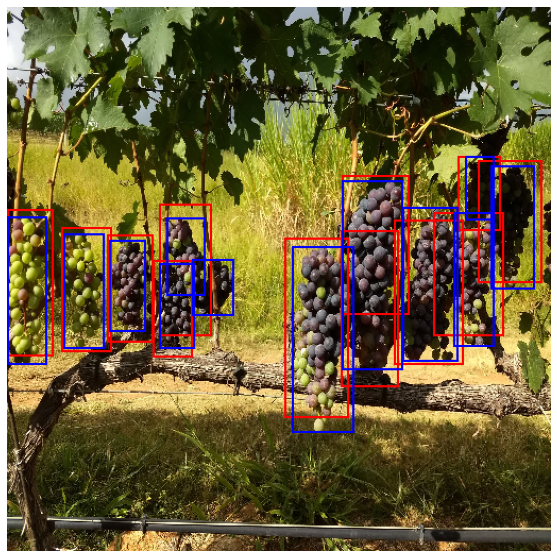

In [58]:
with torch.no_grad():
    output = model(image.unsqueeze(0).to(DEVICE))
output = output.detach().cpu().squeeze(0)
pred_bboxes, pred_scores = output_to_bboxes(output, image.shape[1:], threshold=0.6, nms_threshold=0.5, heatmap_kernel=3)
true_bboxes = denormalize_bboxes(bboxes_gt, image.shape[1:])
plot_image_bounding_boxes(image, pred_bboxes, true_bboxes)

Heatmap of predicted IoUs

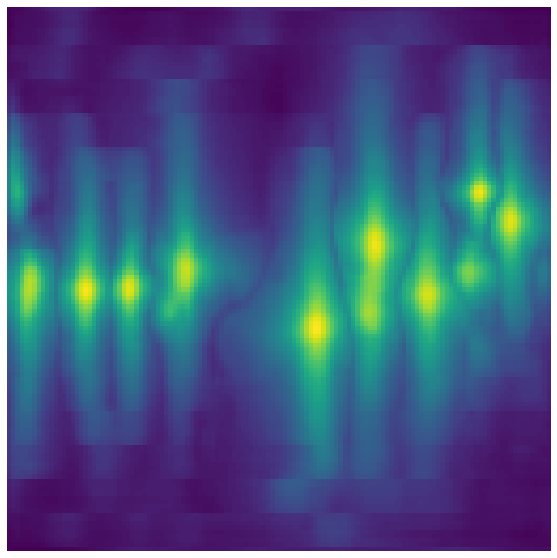

In [59]:
plot_image(TF.to_pil_image(output[..., 4]))